In [ ]:
import tensorflow as tf
import os
import cv2
import glob
import numpy as np
from random import shuffle

<p>steps:


step1:Create a list of filenames: In our case we only have a single file data_path = 'sample.tfrecords'. 
      Therefore, our list is gonna be like this: [data_path]

step2:Create a queue to hold filenames: To do so, we use tf.train.string_input_producer tf.train.string_input_producer 
      function which hold filenames in a FIFO queue. it gets the list of filnames. It also has some optional arguments 
      including  num_epochs which indicates the number of epoch you want to to load the data and shuffle which indicates 
      whether to suffle the filenames in the list or not. It is set to True by default.

step3:Define a reader: For files of TFRecords we need to define a TFRecordReader with reader = tf.TFRecordReader(). Now, 
      the reader returns the next record using: reader.read(filename_queue)

step4:Define a decoder: A decoder is needed to decode the record read by the reader. In case of using TFRecords files the decoder
      should be tf.parse_single_example. it takes a serialized Example and a dictionary which maps feature keys to 
      FixedLenFeature or VarLenFeature values and returns a dictionary which maps feature keys to Tensor values: 
      features = tf.parse_single_example(serialized_example, features=feature)

step5:Convert the data from string back to the numbers: tf.decode_raw(bytes, out_type) takes a Tensor of type string and 
      convert it to typeout_type. However, for labels which have not been converted to string, we just need to cast them using 
      tf.cast(x, dtype)
      
step6:Reshape data into its original shape: You should reshape the data (image) into it's original shape before 
      serialization using  image = tf.reshape(image, [224, 224, 3])

step7:Batching: Another queue is needed to create batches from the examples. You can create the batch queue using 
      tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10) where 
      capacity is the maximum size of queue, min_after_dequeue is the minimum size of queue after dequeue, and num_threads 
      is the number of threads enqueuing examples. Using more than one thread, it comes up with a faster reading. 
      The first argument in a list of tensors which you want to create batches from.
</p>


In [2]:
def _bytes_list(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_list(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _float_list(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [3]:
name="sample_train.tfrecords"

In [4]:
writer=tf.python_io.TFRecordWriter(name)

In [5]:
def processed_image(addr):
   
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

In [6]:

shuffle_data=True
path="PetImages/"
address=[]
values=[]
labels=os.listdir(path)
for i in labels:
    
    address.extend(glob.glob(path+i+"/*"))
    values.extend([1]*len(glob.glob(path+i+"/*")) if i=="Cat" else [0]*len(glob.glob(path+i+"/*")))

if shuffle_data:
    c=list(zip(address,values))
    shuffle(c)
    address,values=zip(*c)

x_valid=address[0:int(0.2*len(address))]
y_valid=values[0:int(0.2*len(values))]

x_test=address[int(0.2*len(address)):int(0.4*len(address))]
y_test=values[int(0.2*len(values)):int(0.4*len(values))]

x_train=address[int(0.4*len(address)):]
y_train=values[int(0.4*len(values)):]



In [7]:
count=0
for i in range(len(x_train)):
    if  i%1000==0:
        print("Completed {} out of {}".format(i,len(x_train)))
    try:
    
        image=processed_image(x_train[i])
        label=y_train[i]
        ph=tf.compat.as_bytes(image.tostring())
        features={
        'image_code':_bytes_list(ph),
        'label_code':_int64_list(label)
             }
        example=tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(example.SerializeToString())
    except:
        count+=1
    
writer.close()
print("{} images were not processed".format(count))

Completed 0 out of 15002
Completed 1000 out of 15002
Completed 2000 out of 15002
Completed 3000 out of 15002
Completed 4000 out of 15002
Completed 5000 out of 15002
Completed 6000 out of 15002
Completed 7000 out of 15002
Completed 8000 out of 15002
Completed 9000 out of 15002
Completed 10000 out of 15002
Completed 11000 out of 15002
Completed 12000 out of 15002
Completed 13000 out of 15002
Completed 14000 out of 15002
Completed 15000 out of 15002
33 images were not processed


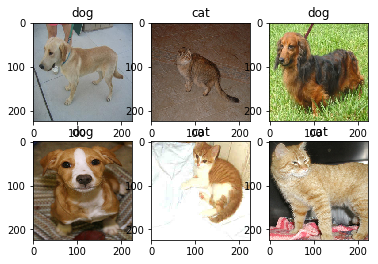

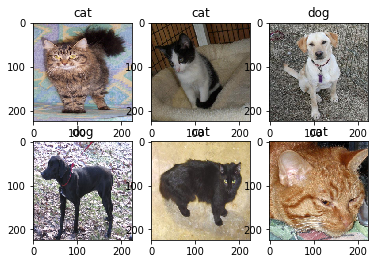

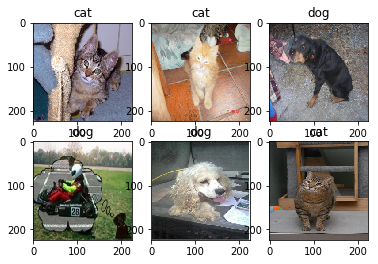

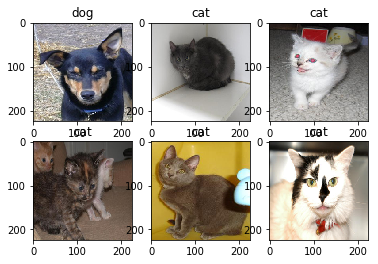

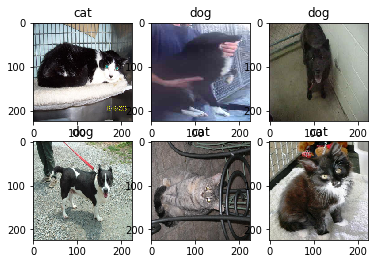

In [10]:
import matplotlib.pyplot as plt
data_path = 'sample_train.tfrecords' 
with tf.Session() as sess:
    feature = {'image_code': tf.FixedLenFeature([], tf.string),
               'label_code': tf.FixedLenFeature([], tf.int64)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['image_code'], tf.float32)
    
    # Cast label data into int32
    label = tf.cast(features['label_code'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [224, 224, 3])
    
    # Any preprocessing here ...
    
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)

    # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for batch_index in range(5):
        img, lbl = sess.run([images, labels])
        img = img.astype(np.uint8)
        for j in range(6):
            plt.subplot(2, 3, j+1)
            plt.imshow(img[j, ...])
            plt.title('cat' if lbl[j]==1 else 'dog')
        plt.show()
    # Stop the threads
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    sess.close()